
# 📒 Escape Artist Agent — Analysis Notebook

This optional notebook helps you **generate and preview figures** for the README using the artifacts saved under `runs/`.

It covers:
1. **Combined learning curves** for multiple runs (MC / MC-OFF / Q).  
2. **Value heatmap + greedy policy arrows** and a **greedy rollout** overlay on a fixed layout.  
3. **Ablations CSV** quick view (if you ran `experiments/ablations.py`).  
4. (Optional) Show the **layout montage** image if you created it.

> Tip: Run the training first using the CLI or `make train-medium`, then come back here.


In [3]:
# Bootstrap: ensure we're at the repo root and the package is installed in THIS kernel
import os
from pathlib import Path
import sys

# If we opened the notebook from experiments/, go up to repo root
if not (Path.cwd() / "pyproject.toml").exists() and (Path.cwd().name == "experiments"):
    os.chdir("..")

print("CWD:", Path.cwd())

# Install/editable into THIS kernel's interpreter
import sys
print("Python:", sys.executable)
%pip install -e .[dev]

# Sanity check import
import escape_artist
print("escape_artist from:", escape_artist.__file__)


CWD: /Users/jsong/workspace/Projects/escape-artist-agent
Python: /Users/jsong/opt/anaconda3/envs/escape-agent/bin/python
zsh:1: no matches found: .[dev]
Note: you may need to restart the kernel to use updated packages.
escape_artist from: /Users/jsong/workspace/Projects/escape-artist-agent/escape_artist/__init__.py


In [4]:

from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Project imports (assumes you're running this from the repo root)
from escape_artist.envs.escape_env import EscapeEnv, EnvConfig
from escape_artist.utils.plotting import (
    plot_learning_curve,
    plot_value_heatmap_and_policy,
    plot_greedy_rollout,
)

# Utility: load returns from a run dir
def load_returns(run_dir: Path) -> np.ndarray:
    p = run_dir / "returns.npy"
    if not p.exists():
        raise FileNotFoundError(f"Missing {p}")
    return np.load(p)

def ensure_dir(p: Path) -> Path:
    p.mkdir(parents=True, exist_ok=True)
    return p



## 1) Combined learning curves

Update the `runs` and `labels` lists to point at your training folders.


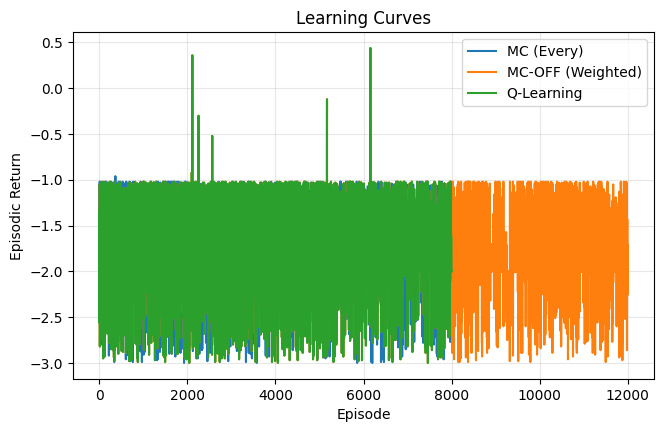

Saved: assets/curve_medium_mc_mc-off_q.png


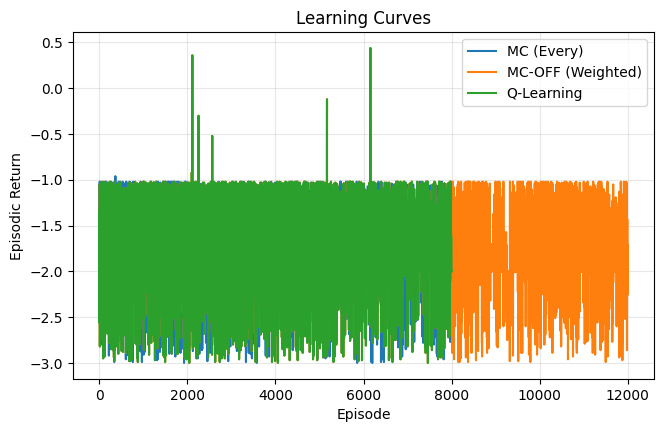

In [6]:

# --- Edit these to your actual run folders ---
runs   = [Path("runs/mc_every_medium"), Path("runs/mc_off_weighted_medium"), Path("runs/q_medium")]
labels = ["MC (Every)", "MC-OFF (Weighted)", "Q-Learning"]

# Plot inline
plt.figure(figsize=(7.5, 4.5))
for run, label in zip(runs, labels):
    r = load_returns(run)
    xs = np.arange(1, len(r) + 1)
    plt.plot(xs, r, label=label)
plt.xlabel("Episode")
plt.ylabel("Episodic Return")
plt.title("Learning Curves")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Also save a copy under assets/
out_path = Path("assets/curve_medium_mc_mc-off_q.png")
ensure_dir(out_path.parent)
plt.figure(figsize=(7.5, 4.5))
for run, label in zip(runs, labels):
    r = load_returns(run)
    xs = np.arange(1, len(r) + 1)
    plt.plot(xs, r, label=label)
plt.xlabel("Episode")
plt.ylabel("Episodic Return")
plt.title("Learning Curves")
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig(out_path, bbox_inches="tight", dpi=150)
print(f"Saved: {out_path}")



## 2) Fixed layout overlays (value heatmap + greedy rollout)

This cell creates a **fixed-layout** environment (so visuals are stable) using the **medium** config settings.  
Then it loads a `Q.npy` from one of your runs and generates two figures:

- `value_heatmap_policy.png` — value heatmap with greedy arrows  
- `greedy_rollout.png` — a single greedy trajectory overlay  


Using config: configs/medium.yaml


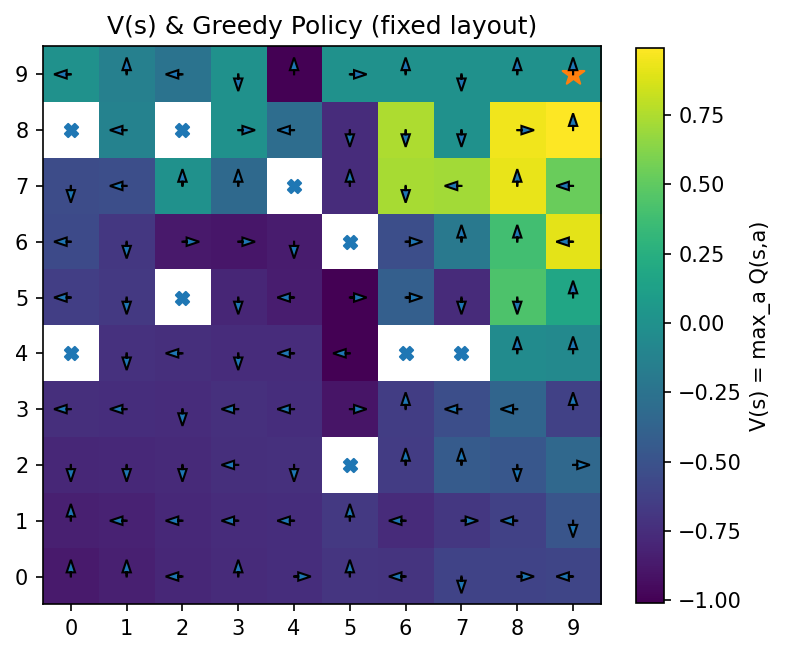

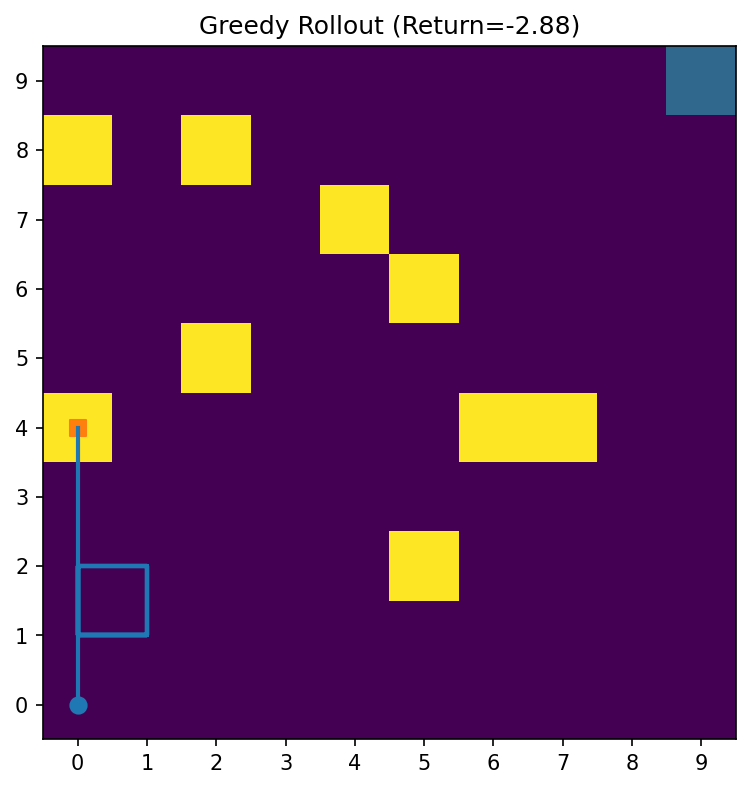

In [8]:

import yaml

# Load a config (use medium by default; change if you like)
cfg_path = Path("configs/medium.yaml")
if not cfg_path.exists():
    # fall back to easy if medium not present
    cfg_path = Path("configs/easy.yaml")
print("Using config:", cfg_path)

with open(cfg_path, "r") as f:
    cfg_all = yaml.safe_load(f)
env_kwargs = cfg_all.get("env", {})

# Build EnvConfig similar to the CLI builder
def tuple_or(v, default):
    return tuple(v) if isinstance(v, (list, tuple)) else default

size = tuple_or(env_kwargs.get("size", (10, 10)), (10, 10))
start = tuple_or(env_kwargs.get("start", (0, 0)), (0, 0))
goal = tuple_or(env_kwargs.get("goal", (size[1]-1, size[0]-1)), (size[1]-1, size[0]-1))

env_cfg = EnvConfig(
    size=size,
    start=start,
    goal=goal,
    traps_pct=float(env_kwargs.get("traps_pct", 0.10)),
    r_safe=int(env_kwargs.get("r_safe", 1)),
    slip=float(env_kwargs.get("slip", 0.1)),
    lethal_traps=bool(env_kwargs.get("lethal_traps", True)),
    step_cost=float(env_kwargs.get("step_cost", -0.01)),
    trap_penalty=float(env_kwargs.get("trap_penalty", -1.0)),
    goal_reward=float(env_kwargs.get("goal_reward", 1.0)),
    max_steps=int(env_kwargs.get("max_steps", 200)),
    layout_mode="per_env",  # fixed layout for clean visuals
    seed=env_kwargs.get("seed", 123),
    obs_mode=str(env_kwargs.get("obs_mode", "pos")),
)

env = EscapeEnv(env_cfg)
env.reset(seed=env.cfg.seed)

# Choose a run to visualize (change as needed)
run_for_Q = Path("runs/q_medium")  # e.g., q_medium or mc_off_weighted_medium
Q_path = run_for_Q / "Q.npy"
assert Q_path.exists(), f"Cannot find {Q_path}. Train first or change run_for_Q."
Q = np.load(Q_path)

# Generate figures to assets/
assets_dir = ensure_dir(Path("assets"))
plot_value_heatmap_and_policy(env, Q, assets_dir, title="V(s) & Greedy Policy (fixed layout)")
from escape_artist.algos.mc_control import greedy_policy_rollout
plot_greedy_rollout(env, Q, greedy_policy_rollout, assets_dir, max_steps=env.cfg.max_steps)

display(Image(filename=str(assets_dir / "figs" / "value_heatmap_policy.png"), width=420))
display(Image(filename=str(assets_dir / "figs" / "greedy_rollout.png"), width=420))



## 3) Ablations quick view (if available)

If you ran `python -m experiments.ablations` (or used a Makefile target), this section will:

- Load `assets/ablations_mc_q.csv`  
- Show the first few rows  
- Render simple heatmaps for success rates (MC Every-Visit & Q-Learning)


,size,slip,traps_pct,algo,success_rate,avg_return
0,10x10,0.0,0.05,MC-every,0.566667,-0.010000
1,10x10,0.0,0.05,Q-learning,0.500000,-0.138667
2,10x10,0.0,0.10,MC-every,0.000000,-2.000000
3,10x10,0.0,0.10,Q-learning,0.000000,-2.000000
4,10x10,0.0,0.15,MC-every,0.000000,-2.000000


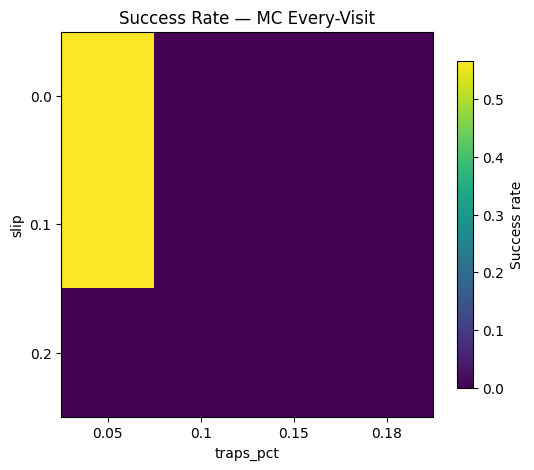

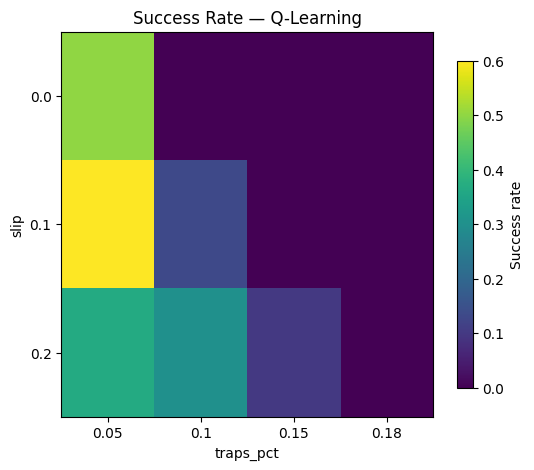

In [10]:

import pandas as pd

csv_path = Path("assets/ablations_mc_q.csv")
if not csv_path.exists():
    print("No ablations CSV found. Run: python -m experiments.ablations")
else:
    df = pd.read_csv(csv_path)
    display(df.head())

    # Pivot success matrices
    def pivot_success(df_algo):
        # rows = slip, cols = traps_pct
        piv = df_algo.pivot_table(index="slip", columns="traps_pct", values="success_rate", aggfunc="mean")
        return piv.sort_index(axis=0).sort_index(axis=1)

    df_mc = df[df["algo"] == "MC-every"]
    df_q  = df[df["algo"] == "Q-learning"]
    piv_mc = pivot_success(df_mc)
    piv_q  = pivot_success(df_q)

    # Plot each heatmap
    for name, piv in [("MC Every-Visit", piv_mc), ("Q-Learning", piv_q)]:
        plt.figure(figsize=(6, 5))
        plt.imshow(piv.values, origin="upper", aspect="auto")
        plt.colorbar(shrink=0.85, label="Success rate")
        plt.xticks(range(len(piv.columns)), [str(c) for c in piv.columns])
        plt.yticks(range(len(piv.index)), [str(i) for i in piv.index])
        plt.xlabel("traps_pct")
        plt.ylabel("slip")
        plt.title(f"Success Rate — {name}")
        plt.show()



## 4) Layout montage (optional)

If you created the montage with `python -m experiments.make_layout_montage`, display it below.


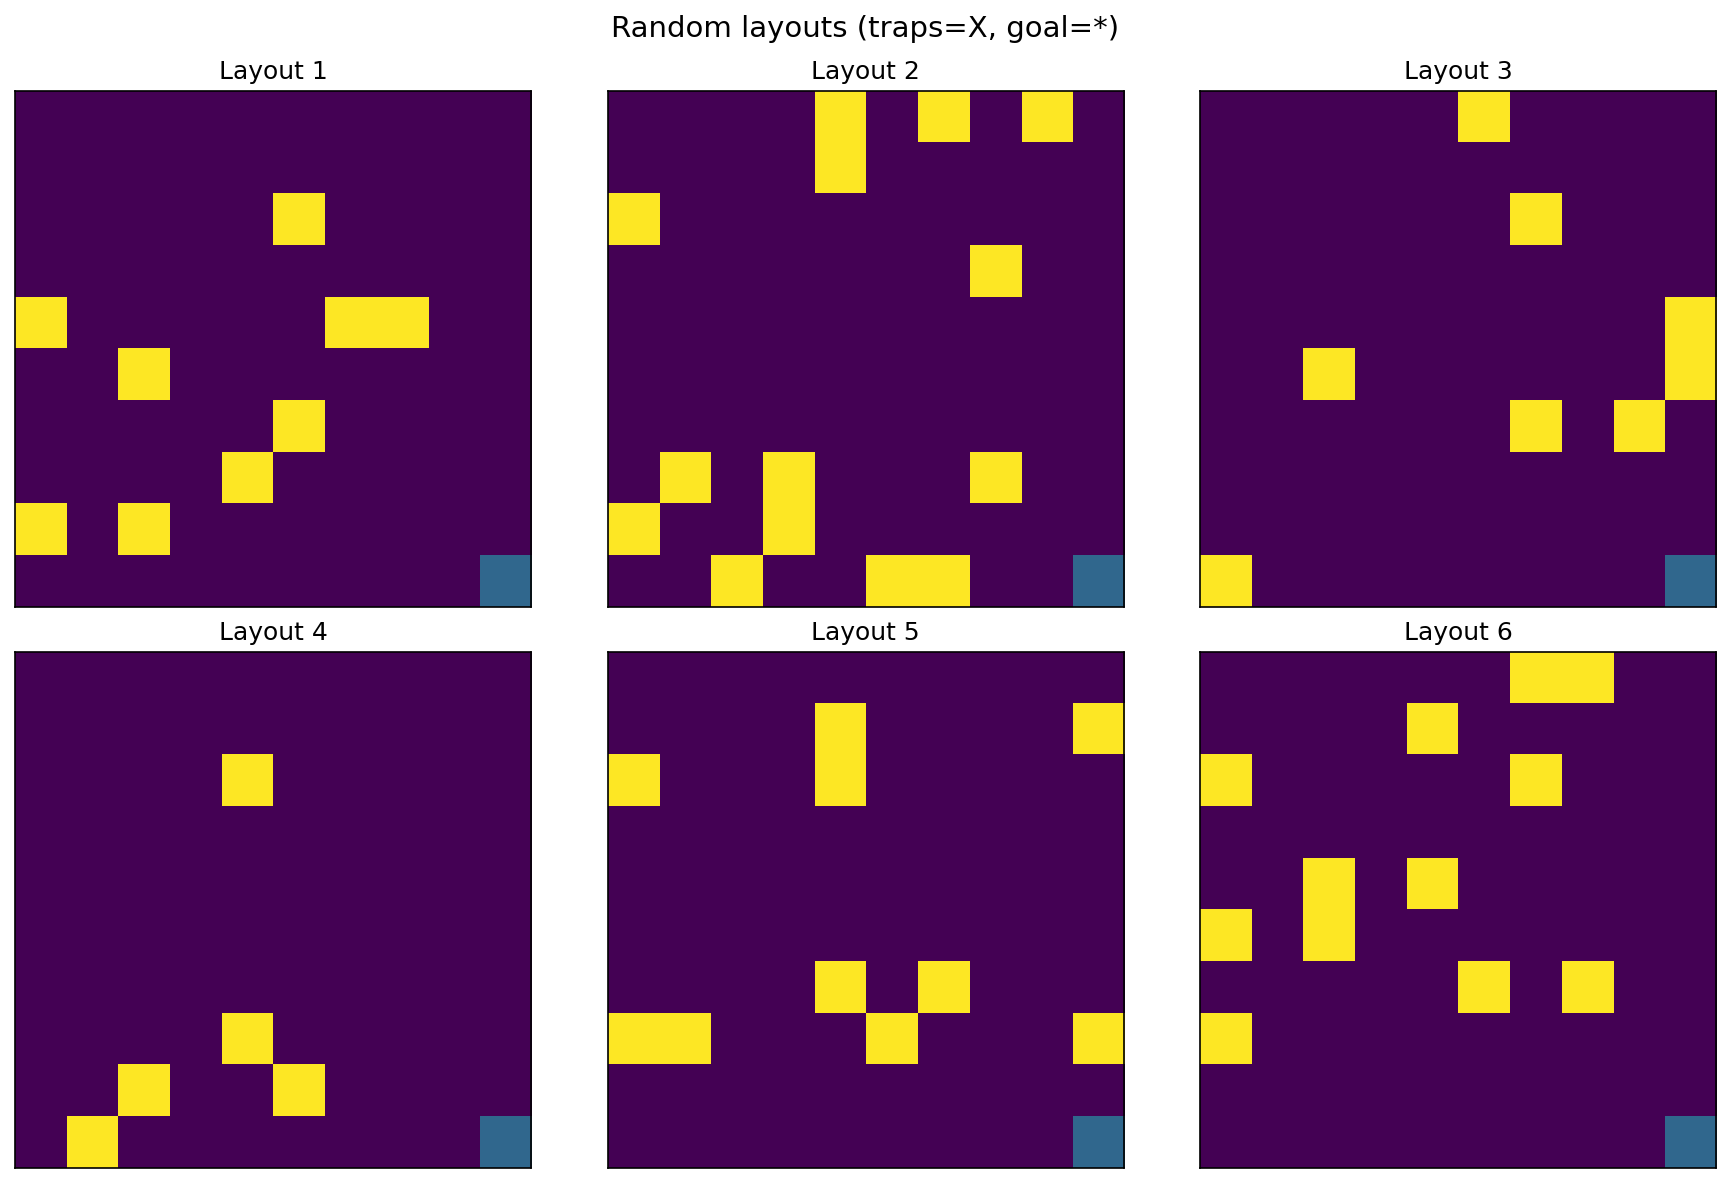

In [11]:

montage_path = Path("assets/layout_montage.png")
if montage_path.exists():
    display(Image(filename=str(montage_path), width=720))
else:
    print("No montage found. Run: python -m experiments.make_layout_montage --out assets/layout_montage.png")
